# Daymet V4 - Programmatic Data Discovery, Access, Subsetting, and Download for Analysis Ready Data

**Please note that the link to access daymet data used here is subject to change and may need to periodically updated**

*Original Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*
<br>
*Link to [Original Notebook](https://github.com/ornldaac/daymet-python-opendap-xarray)*
<br>
*Editor:  Teagan Baiotto*
<br>
*Last Edited:  January 19, 2023*


## Daymet Overview
**Daymet** provides long-term, continuous, gridded estimates of daily weather and climatology variables by interpolating and extrapolating ground-based observations through statistical modeling techniques. 

Daily files are produced on a **1km x 1km** spatial grid and distributed in a multidimensional, netCDF, file format. Daymet data is available for continenal North America (na), with Hawaii (hi), and Puerto Rico (pr) as separate data files.

DAYMET Temporal Availability:

| Spatial Area    | Years                          
|:---------       |:---------------------------------------:|
| North America   | 1980 - present
| Hawaii          | 1980 - 2020
| Puerto Rico     | 1950 - 2020

DAYMET VARIABLES:

| Variable | Description (units)                           
|:---------|:---------------------------------------:|
| tmax     | Daily maximum 2-meter air temperature (°C)
| tmin     | Daily minimum 2-meter air temperature (°C)
| prcp     | Daily total precipitation (mm/day)
| srad     | Incident shortwave radiation flux density (W/m2)
| vp       | Water vapor pressure (Pa)
| swe      | Snow water equivalent (kg/m2)
| dayl     | Duration of the daylight period (seconds/day)


Daymet V4 Daily Data files (or granules) are natively in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for na, pr, hi).

The standard naming convention for a file is:  

- daymet_v4_daily_`area`_`variable`_`year`.nc


#### Daymet Data: ORNL DAAC 
- The [Daymet Website](https://daymet.ornl.gov) provides comprehensive information about and access methods for the Daymet datasets under the [Get Data](https://daymet.ornl.gov/getdata) tab. 

- Landing Page for [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840).  
- Daymet V4 Daily Data dataset DOI **https://doi.org/10.3334/ORNLDAAC/1840**
<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S. Kao, and B.E. Wilson. 2020. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1840
</div>


- ORNL DAAC access to Daymet daily data through THREDDS Data Server (TDS) [Daymet V4 Daily Data: THREDDS](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1840/catalog.html)

#### Daymet Data: NASA Earthdata
 - [NASA Earthdata Daymet Collections](https://search.earthdata.nasa.gov/portal/ornldaac/search?fpj=Daymet!Daymet!Daymet)

***
***

<div class="alert alert-block alert-danger">
<b> Project Name Setting: </b> Please set the Project Name and Cell Resolution for your project </div>

In [1]:
# CHANGE PROJECT NAME HERE
PROJECT_NAME = 'Test'

# CURRENT DIRECTORY HERE, SET WHERE THE NOTEBOOKS ARE LOCATED
CURRENT_DIRECTORY = '/home/teaganbaiotto/Documents/bbgci'

# SET THE SPATIAL RESOLUTION (in meters)
SPATIAL_RESOLUTION = 30

In [2]:
import os, shutil
os.chdir(CURRENT_DIRECTORY)

In [3]:
# Define folder paths as global variables
PROJECT_DIR = os.path.join(CURRENT_DIRECTORY, PROJECT_NAME)
RAWGIS_DIR = os.path.join(PROJECT_DIR, "gis_data")
RAWOBS_DIR = os.path.join(PROJECT_DIR, "obs")
RAWSOIL_DIR = os.path.join(RAWGIS_DIR, "soil")
MODEL_DIR = os.path.join(PROJECT_DIR, 'model')
DEF_DIR = os.path.join(MODEL_DIR, 'defs')
INI_DIR = os.path.join(MODEL_DIR, 'ini_files')
EPC_DIR = os.path.join(MODEL_DIR, 'epc_files')
OUTPUT_DIR = os.path.join(MODEL_DIR, 'output')
CO2_DIR = os.path.join(MODEL_DIR, 'co2')
NDEP_DIR = os.path.join(MODEL_DIR, 'ndep')
ENDPOINT_DIR = os.path.join(MODEL_DIR, 'endpoint_files')
SPINUP_DIR = os.path.join(MODEL_DIR, 'spinup')
NORMAL_DIR = os.path.join(MODEL_DIR, 'normal')
MODEL_RAST_DIR = os.path.join(MODEL_DIR, 'raster_inputs')
IMAGE = os.path.join(PROJECT_DIR, 'image_map')

In [4]:
# Install necessary packages. If errors, try un-commenting the other packages and re-running this cell.

# !pip install geopandas
# !pip install pyproj
# !pip install rioxarray
# !pip install xarray
# !pip install shapely
# !pip install descartes

In [5]:
# Import necessary packages
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pyproj
from pyproj import CRS, Transformer, Proj, transform
import datetime as dt 
import xarray as xr
import rioxarray
import shapely
import rasterio
from rasterio.features import Affine
import time
from shapely.geometry import mapping
from netCDF4 import Dataset

In [6]:
print("This Notebook was produced with the following versions")
print("geopanda version   : ", gpd.__version__)
print("pyproj version     : ", pyproj.__version__)
print("rioxarray version  : ", rioxarray.__version__)
print("xarray version     : ", xr.__version__)
print("shapely            : ", shapely.__version__)
print("rasterio           : ", rasterio.__version__)

This Notebook was produced with the following versions
geopanda version   :  0.8.2
pyproj version     :  3.0.0.post1
rioxarray version  :  0.9.1
xarray version     :  0.20.2
shapely            :  1.7.1
rasterio           :  1.2.10


## Step 1.  Setting Search and Subset Parameters: Spatial Area of Interest and Time Range of Interest

We'll use Python's [GeoPandas](https://geopandas.org/index.html) to provide a spatial extent from our AOI shapefile.

* **`Geopandas`** is a Python library that enables the use and manipulation of geospatial data. It extends the common datatype used in pandas to allow for many and unique geometric operations.

In [7]:
# Read in AOI shapefile
aoi = gpd.read_file(os.path.join(RAWGIS_DIR, 'AOI.shp'))
aoi = aoi.to_crs("EPSG:4326") # to_crs re-projects to WGS84, if it is not already in that projection
# ax = aoi.plot()

aoi.crs  # Lists the coordinate reference system (crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As we see above, the boundary file is in the `WGS 84` projection. Daymet is project to the `lambert_conformal_conic (LCC)` system. 

### Re-project vector file using the **`GeoDataFrame.to_crs`** 
We'll need bounding box coordinates in 2 reference systems
1. **Geographic** - for searching NASA Earthdata metadata
2. **Lambert Conformal Conic** - Daymet's crs - for subsetting the file using OPeNDAP protocols

### 1.1 **Geographic** bounding box - for searching NASA Earthdata metadata

In [8]:
# Let's determine and store the geographic bounding box of the Park boundary for Earthdata Searching
# data can be re-projected using the GeoDataFrame.to_crs() command:

xy = aoi.bounds # bound of polygon in lat, lon 
print(xy)

        minx       miny      maxx       maxy
0 -78.076302  38.836212 -78.03596  38.867227


In [9]:
xy = aoi.bounds.values.tolist()[0] # We'll need the bounding box as a Python list 
                                              # to server as a subsetting parameter
print(xy)

[-78.076302, 38.836212, -78.03596, 38.867227]


### 1.2. **Lambert Conformal Conic** bounding box - Daymet's CRS - for subsetting the file using OPeNDAP protocols

In [10]:
# Defining Daymet proj - we'll use this in a later step
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
aoi_lcc = aoi.to_crs(daymet_proj) # to_crs re-projects from UTM 17N to LCC
lccbounds = aoi_lcc.bounds # Bounds in LCC projection
lccbounds.round(2)

,minx,miny,maxx,maxy
0,1799102.9,-149750.1,1802543.66,-146971.05


In [11]:
# Plot differences in AOI appearance in original and projected coordinate system
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
#grsm_poly.plot(ax=ax1, facecolor='blue');
aoi.plot(ax=ax1, facecolor='blue');
ax1.set_title("AOI Geographic Coordinate System");
aoi_lcc.plot(ax=ax2, facecolor='grey');
ax2.set_title("AOI Daymet LCC Projection");
plt.tight_layout()

In [12]:
# Extend AOI by 1 km on each side to ensure data is downloaded for full extent
x_lower, y_lower, x_upper, y_upper = lccbounds.round(2).values.tolist()[0][0] - 1000, lccbounds.round(2).values.tolist()[0][1] - 1000, lccbounds.round(2).values.tolist()[0][2] + 1000, lccbounds.round(2).values.tolist()[0][3] + 1000
lccbounds.minx[0], lccbounds.miny[0], lccbounds.maxx[0], lccbounds.maxy[0] = x_lower, y_lower, x_upper, y_upper
lccbounds

,minx,miny,maxx,maxy
0,1798102.9,-150750.1,1803543.66,-145971.05


### 1.3. Let's also define a `time range` in a format that the API recognizes, and the Daymet `variables` of interest

<div class="alert alert-block alert-danger">
<b> Project Dates: </b> Please set start and end date for model simulation </div>

In [13]:
# Date format = (YYYY, MM, DD)
start_date = dt.datetime(1980, 1, 1) # specify your own start date
end_date = dt.datetime(2021, 12, 31)  # specify your end start date

In [14]:
dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

variables = ['prcp', 'tmax', 'tmin', 'dayl', 'srad', 'vp'] # select a Daymet variable of interest
print(temporal_str)
print(variables)

1980-01-01T00:00:00Z,2021-12-31T00:00:00Z
['prcp', 'tmax', 'tmin', 'dayl', 'srad', 'vp']


----

## Step 2. Leveraging NASA's Common Metadata Repository (CMR) API to search for Daymet data within a spatial and temporal region of interest

##### Now that we've defined our spatial and temporal area-of-interest, we'll see how we can programatically use those as a search parameters to discover Daymet V4 Daily data.  

##### At the end of this step, we will have a list of Daymet files that are within our search criteria (bounding box and time period).

#### A little background ...

- Searching [NASA's Earthdata Holdings](https://search.earthdata.nasa.gov/search) can lead to quite a few files for a user to consider. 
![title](images/InkedNASAEarthdataCollectionSearch_narrow_LI.jpg)
<br>

Some helpful background:
- NASA has a metadata system that catalogs all data and metadata records:  [Common Metadata Repository (CMR)](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr) 

- Using the [CMR API](https://cmr.earthdata.nasa.gov/search), we can search metadata records to discovered data granules (files).


**`Request URL's`**
<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

- The [Daymet V4 Daily](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840) data DOI, **`doi.org/10.3334/ORNLDAAC/1840`**.
   

### 2.1. Searching NASA's Earthdata Collections for Daymet V4 Daily Data "`Concept ID`"

#### The **`Concept ID`** is a NASA Earthdata unique ID for **Dataset Collections**.  We'll see how to programatically obtain the Concept ID below.

Using Python's **`requests`** library, we will build and provide an HTTP request to search **`NASA's Earthdata Collections`** for Daymet V4 Daily Dataset Collection to acquire the **`concept_id`** unique to the Daymet V4 Daily data in NASA's Earthdata holdings.  

* **`requests`** is a simple HTTP libray for Python.  It allows you to easily send HTTP requests.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

To build the URL Request we'll use:
- the CMR Request URL
- Daymet V4 Daily Data DOI


In [15]:
daymet_doi = '10.3334/ORNLDAAC/2129' # define the Daymet V4 Daily Data DOI as the variable `daymet_doi`. UPDATE THIS IF NOT WORKING
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # Create the Earthdata Collections URL
print('Earthdata Collections URL: Daymet V4 Daily -->', doisearch)

Earthdata Collections URL: Daymet V4 Daily --> https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/2129


In [16]:
# From the doisearch, we can obtain the ConceptID for the Daymet V4 Daily data
# We'll search the json response of the Daymet metadata for "id" within the 'entry' dictionary key
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0] 
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Concept_ID --> ' , concept_id)

NASA Earthdata Concept_ID -->  C2532426483-ORNL_CLOUD


`C2031536952-ORNL_CLOUD` is the unique NASA-given Concept ID for the Daymet V4 Daily data Collection. We'll use this to search for Daymet V4 Daily files (granules) that match our search criteria. 

### 2.2. Searching NASA's Earthdata Holdings for Daymet `Granules` (Files)
#### Now that we have all our parameters defined, let's search NASA's Earthdata Granules for all the data that are within those search criteria.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>


In [17]:
print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variables :', variables)
print('bounding box    :')
print(xy)
print('concept ID      :', concept_id)
print('cmr url         :', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1980-01-01T00:00:00Z,2021-12-31T00:00:00Z
Daymet variables : ['prcp', 'tmax', 'tmin', 'dayl', 'srad', 'vp']
bounding box    :
[-78.076302, 38.836212, -78.03596, 38.867227]
concept ID      : C2532426483-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### 2.2.a. We'll build a Request URL `granulesearch` to create a listing of all the granules (files) in NASA's Earthdata holdings that fit the search criteria we defined.

In [18]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy))
print(granulesearch)                

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2532426483-ORNL_CLOUD&page_size=1000&temporal=1980-01-01T00:00:00Z,2021-12-31T00:00:00Z&bounding_box[]=-78.076302,38.836212,-78.03596,38.867227


### 2.2.b. Again using Python's **`requests`** library, we can provide the URL `granulesearch` to create a listing of all the granules (files) in **NASA's Earthdata** holdings that fit the search criteria we defined.

In [19]:
# Create list of granules we want

response = requests.get(granulesearch)
granules = response.json()['feed']['entry'] 
granule_names = {}  # create an empty array
for var in variables:
    granule_names[var] = []
    
for g in granules:
    granule_name = g['title'] # fill the array with granule names that match our search parameters
    for var in granule_names.keys():
        if var in granule_name:
            granule_names[var].append(granule_name)
            print(granule_name)

Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_srad_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_vp_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1981.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_1981.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_vp_1981.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_1981.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_srad_1981.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1981.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1982.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1982.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_1982.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_1982.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_vp_1982.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_srad_1982.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1983.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1983.nc
Daymet

----

## Step 3. Downloading subset data through ORNL DAAC THREDDS Data Server
Daymet V4 Daily data is available through ORNL DAAC's THREDDS Data Server. 


[Daymet V4 Daily Data in the ORNL DAAC THREDDS Data Server](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1840/catalog.html)

### 3.1. **`OPeNDAP`** allows users to use data files that are stored on remote computers with their favorite analysis and visualization client software.

NASA Earthdata has great informaion on OPeNDAP: [What is OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap)

### 3.1.a. We'll use Pythons **`netCDF4`** library
* connect to OPeNDAP service and subset data 

### 3.1.b. We'll use Python's **`Xarray`** Library to 
* open the data files we are searching for, 
* subset the North American file based on the Lambert Conformal Conic **`lccbounds`** bounding box we defined earlier, 
* concatenate the time range of files into one file, and 
* save the concatened file to a netCDF file.

netCDF4
* **Dataset**

Xarray
* **open_dataset** 
* **slice**
* **concat**
* **to_netcdf**

We will subset and download Daymet V4 Daily Data based on
- **`granual_names`** array we saved above 
- our polygonal region of interest (LCC bounding box)
- our time range of interest
- Daymet variable



**Note:** The beginning of the **`granule_names`** filename (**"Daymet_Daily_V4."**) is specific to the Earthdata naming convention.  We'll strip out (**"Daymet_Daily_V4."**) below when we access the files from the on-prem ORNL DAAC's OPeNDAP client through THREDDS.

In [20]:
import multiprocessing
# specify an url, the JARKUS dataset in this case
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/' # ORNL DAAC TDS OPeNDAP URL 
                                                                           # for Daymet V4 Daily Files
before = time.time()
    
def var_retrieval(var):
    cnt = 0
    for g_name in granule_names[var]:
        print(' ***GRANULE_NAME*** ---->', g_name)
        granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4R1.','')
        print(granule_dap)

        # Using netcdf's dataset 
        thredds_ds = Dataset(granule_dap)

        ds = xr.open_dataset(xr.backends.NetCDF4DataStore(thredds_ds), decode_coords="all")

        temp=ds[var].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))

        if cnt==0:
            var_data = temp
        else:
            var_data = xr.concat([var_data, temp], dim="time")

        cnt += 1
        
    var_data.to_netcdf(os.path.join(MODEL_DIR, 'met_data', f'{var}.nc'))

pool = multiprocessing.Pool(processes=10)
pool.map(var_retrieval, variables)

print("Processing Time: ", time.time() - before, 'seconds')

 ***GRANULE_NAME*** ----> ***GRANULE_NAME*** ----> ***GRANULE_NAME*** ----> ***GRANULE_NAME*** ---->  ***GRANULE_NAME*** ----> ***GRANULE_NAME*** ---->   Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_1980.nc Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1980.nc Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1980.ncDaymet_Daily_V4R1.daymet_v4_daily_na_dayl_1980.nc
Daymet_Daily_V4R1.daymet_v4_daily_na_vp_1980.nc

Daymet_Daily_V4R1.daymet_v4_daily_na_srad_1980.nchttps://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1980.nc

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmin_1980.nchttps://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmax_1980.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_1980.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_dayl_1980.nc

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_srad_1980.nc


 ***GRAN

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_dayl_1990.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1989.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmax_1989.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_srad_1986.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_srad_1986.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_1991.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_1991.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1988.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmin_1988.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_1991.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_dayl_1991.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_1985.nc
https:

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmax_1997.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2002.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2002.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_2001.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_dayl_2001.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_1996.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmin_1996.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2003.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2003.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_2002.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_dayl_2002.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_1998.nc
http

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2013.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_2004.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmin_2004.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2005.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmax_2005.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_srad_1998.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_srad_1998.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_dayl_2013.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_dayl_2013.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2014.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2014.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2006.nc
http

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmin_2013.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_srad_2005.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_srad_2005.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_2014.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmin_2014.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2015.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_tmax_2015.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_srad_2006.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_srad_2006.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_1999.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_1999.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_tmin_2015.nc
https://

 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_2016.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_2016.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_2017.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_2017.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_2018.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_2018.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_2019.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_2019.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_2020.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_2020.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_vp_2021.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_vp_2021.nc
Processing Time:  1139.61909

### 3.1.c.  Combine Individual Data Arrays into Xarray.Dataset

Each data variable was downloaded seperately, so we will need to now combine them for easier use later. The python module **Xarray** has a merge function which allows multiple datasets with the same coordinates/dimensions but different variables to be combined together.

In [21]:
count = 0
for var in variables:
    if count == 0:
        combined = xr.open_dataset(os.path.join(MODEL_DIR, 'met_data', f'{var}.nc'))
    else:
        combined = xr.merge([combined, xr.open_dataset(os.path.join(MODEL_DIR, 'met_data', f'{var}.nc'))])
    count += 1

display(combined)

<xarray.Dataset>
Dimensions:                  (x: 5, y: 5, time: 15330)
Coordinates:
  * x                        (x) float32 1.799e+06 1.8e+06 ... 1.803e+06
  * y                        (y) float32 -1.46e+05 -1.47e+05 ... -1.5e+05
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
    lat                      (time, y, x) float32 38.88 38.88 ... 38.84 38.83
    lon                      (time, y, x) float32 -78.07 -78.06 ... -78.04
Data variables:
    lambert_conformal_conic  int16 -32767
    prcp                     (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    dayl                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...

### 3.2 Visualize Daymet Tmin Subset

Create a map of one array of data contained within the data downloaded above. Doing so allows for a superficial check to make sure everything downloaded correctly.

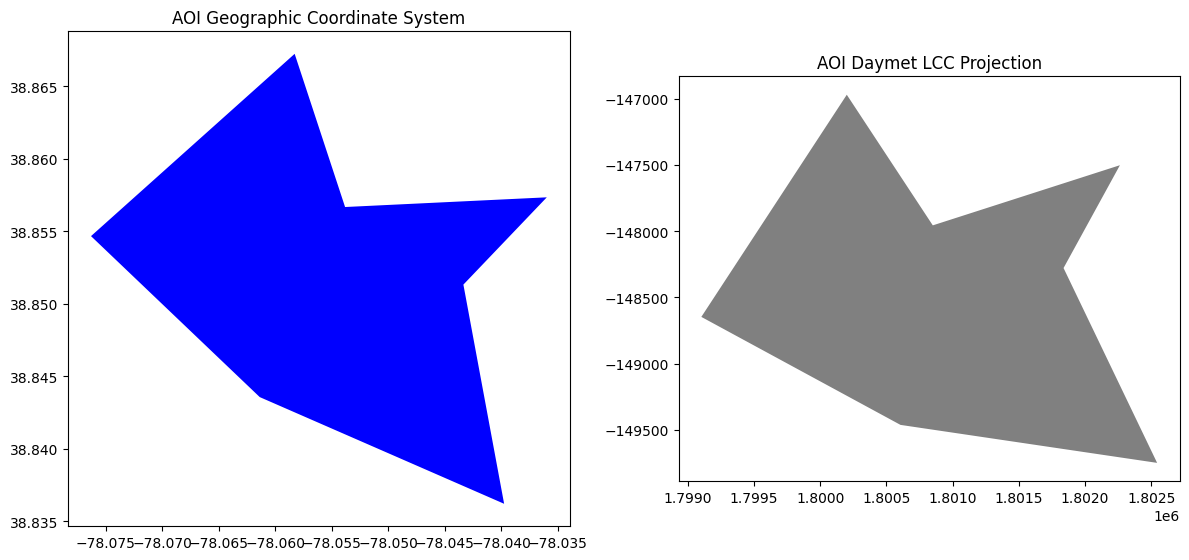

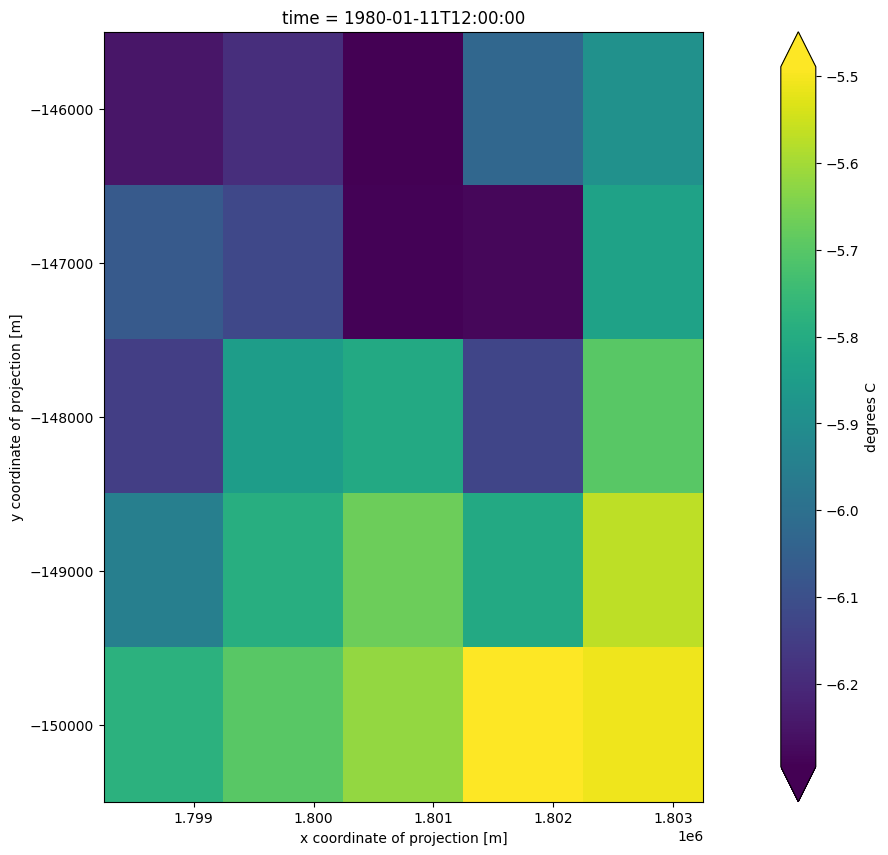

In [22]:
prcp_grsm = combined['tmin'].isel(time=10) # isel = xarray index selection (python index start from 0, so time is Jan 7, 2010)
fig, ax = plt.subplots(figsize = (20,10))
prcp_grsm.plot(ax=ax, robust=True, cbar_kwargs={'label': 'degrees C'})
aoi.plot(ax = ax, color = 'none', edgecolor = 'red')
plt.show()

----

### 3.3 Save to Netcdf in Model Directory

Save the Daymet meteorological data as a netcdf to be opened in next steps.

In [23]:
combined.to_netcdf(os.path.join(MODEL_DIR, 'met_data', 'aoi_met.nc'))